## Classification using PyTorch

## Getting the data ready

In [1]:
# dummy/toy dataset
import numpy as np
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [5]:
# making the dataframe of the data
import pandas as pd
df = pd.DataFrame({"X1":X[:,0],
                   "X2":X[:,1],
                   "labels":y})

df.head()

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


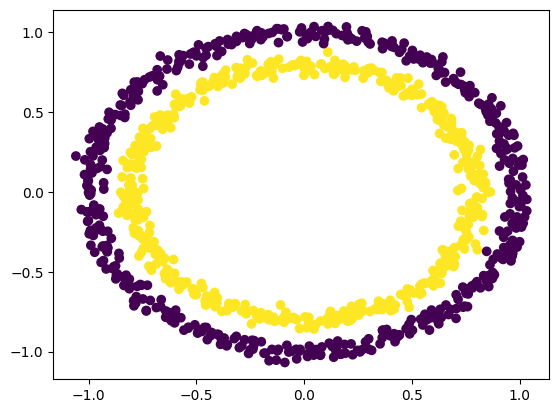

In [6]:
# visualizing the dataset
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y)

In [7]:
# check input and output shapes
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

## Turn data into tensors and split the dataset

In [9]:
import torch
torch.__version__

'2.4.1+cu121'

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
type(X), X.dtype, y.dtype, X.shape, y.shape

(torch.Tensor,
 torch.float32,
 torch.float32,
 torch.Size([1000, 2]),
 torch.Size([1000]))

In [13]:
# split dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2,
                                                    stratify=y)

In [14]:
# to ensure the dataset is evenly divided
torch.unique(y_train, return_counts=True)

(tensor([0., 1.]), tensor([400, 400]))

## Building a model

In [15]:
# Write device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now building the model by subclassing nn.Module class

In [16]:
from torch import nn

class logisticRegression(nn.Module):
    def __init__(self):
      super().__init__()
      # create 2 linear layers
      self.linear_layer_1 = nn.Linear(in_features=2, out_features=5)
      self.linear_layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
      return self.linear_layer_2(self.linear_layer_1(x))


In [17]:
model_0 = logisticRegression().to(device)

In [18]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [19]:
pytorch_total_params = sum(p.numel() for p in model_0.parameters() if p.requires_grad)

In [20]:
pytorch_total_params

21

In [21]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [22]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5887, -0.3446],
                      [-0.5341,  0.5889],
                      [ 0.3621,  0.0848],
                      [ 0.3628,  0.4164],
                      [-0.2506,  0.0651]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0617,  0.1395, -0.5175, -0.1410, -0.0629], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3518,  0.1507,  0.3337, -0.3895, -0.0241]], device='cuda:0')),
             ('1.bias', tensor([0.2687], device='cuda:0'))])

In [24]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(torch.round(untrained_preds[:5]))

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


In [25]:
# set up loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [26]:
# defining a accuracy metric
def accuracy_fn(y_pred, y_true):
  correct = torch.eq(y_pred, y_true).sum().item()
  accuracy = correct/len(y_pred)
  return accuracy

## Train model

In [27]:
# Going from raw logits -> prediction probabilities -> prediction labels
# Model outputs are raw logits.
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[0.3040],
        [0.0840],
        [0.1147],
        [0.0637],
        [0.2079]], device='cuda:0')

In [28]:
# convert logits into probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5754],
        [0.5210],
        [0.5286],
        [0.5159],
        [0.5518]], device='cuda:0')

In [29]:
y_preds = torch.round(y_pred_probs)

# in full (logits -> prediction probabilities -> prediction labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

In [30]:
# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

### Building a training and testing loop

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  # training
  model_0.train()

  # forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # backpropagation
  loss.backward()

  # optimizer ster
  optimizer.step()

  # model testing
  model_0.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate tess loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch%100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69903 | Accuracy: 0.50% | Test Loss: 0.69801 | Test Accuracy: 0.50%
Epoch: 100 | Loss: 0.69618 | Accuracy: 0.50% | Test Loss: 0.69541 | Test Accuracy: 0.50%
Epoch: 200 | Loss: 0.69485 | Accuracy: 0.56% | Test Loss: 0.69426 | Test Accuracy: 0.55%
Epoch: 300 | Loss: 0.69418 | Accuracy: 0.53% | Test Loss: 0.69375 | Test Accuracy: 0.52%
Epoch: 400 | Loss: 0.69382 | Accuracy: 0.52% | Test Loss: 0.69351 | Test Accuracy: 0.52%
Epoch: 500 | Loss: 0.69361 | Accuracy: 0.52% | Test Loss: 0.69341 | Test Accuracy: 0.49%
Epoch: 600 | Loss: 0.69347 | Accuracy: 0.52% | Test Loss: 0.69336 | Test Accuracy: 0.49%
Epoch: 700 | Loss: 0.69338 | Accuracy: 0.51% | Test Loss: 0.69334 | Test Accuracy: 0.49%
Epoch: 800 | Loss: 0.69331 | Accuracy: 0.51% | Test Loss: 0.69334 | Test Accuracy: 0.49%
Epoch: 900 | Loss: 0.69326 | Accuracy: 0.51% | Test Loss: 0.69335 | Test Accuracy: 0.49%


## Make predictions and evaluate model

In [32]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("File already exists")

else:
  print("Downloading file")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [33]:
from helper_functions import plot_decision_boundary

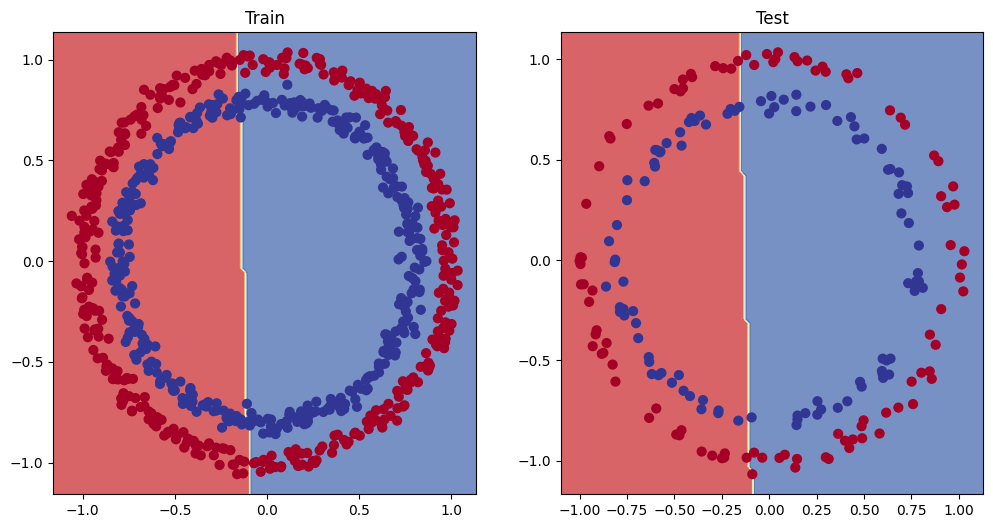

In [34]:
# plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving the model

Building the model with non-linearity

In [61]:
class logisticRegressionV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_1 = nn.Linear(in_features=2, out_features=10)
    self.linear_2 = nn.Linear(in_features=10, out_features=10)
    self.linear_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear_3(self.relu(self.linear_2(self.relu(self.linear_1(x)))))

model_1 = logisticRegressionV2().to(device)
model_1

logisticRegressionV2(
  (linear_1): Linear(in_features=2, out_features=10, bias=True)
  (linear_2): Linear(in_features=10, out_features=10, bias=True)
  (linear_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [62]:
model_1.state_dict()

OrderedDict([('linear_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('linear_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('linear_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.

In [66]:
# loss
loss_fn = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(model_1.parameters(),
                             lr=0.1)

In [63]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [68]:
# training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  # train mode
  model_1.train()

  # forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # optimizer step
  optimizer.step()

  # testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.53752 | Accuracy: 0.86% | Test Loss: 0.53979 | Test Accuracy: 0.85%
Epoch: 100 | Loss: 0.44400 | Accuracy: 0.93% | Test Loss: 0.44424 | Test Accuracy: 0.94%
Epoch: 200 | Loss: 0.32693 | Accuracy: 0.98% | Test Loss: 0.32943 | Test Accuracy: 0.98%
Epoch: 300 | Loss: 0.22004 | Accuracy: 1.00% | Test Loss: 0.22629 | Test Accuracy: 0.99%
Epoch: 400 | Loss: 0.15086 | Accuracy: 1.00% | Test Loss: 0.15820 | Test Accuracy: 0.99%
Epoch: 500 | Loss: 0.10727 | Accuracy: 1.00% | Test Loss: 0.11451 | Test Accuracy: 0.99%
Epoch: 600 | Loss: 0.08014 | Accuracy: 1.00% | Test Loss: 0.08663 | Test Accuracy: 1.00%
Epoch: 700 | Loss: 0.06366 | Accuracy: 1.00% | Test Loss: 0.06955 | Test Accuracy: 1.00%
Epoch: 800 | Loss: 0.05257 | Accuracy: 1.00% | Test Loss: 0.05798 | Test Accuracy: 1.00%
Epoch: 900 | Loss: 0.04464 | Accuracy: 1.00% | Test Loss: 0.04981 | Test Accuracy: 1.00%


## Evaluating the model

In [69]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_test).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

y_pred[:10], y_test[:10]

(tensor([1., 0., 0., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0'),
 tensor([1., 0., 0., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0'))

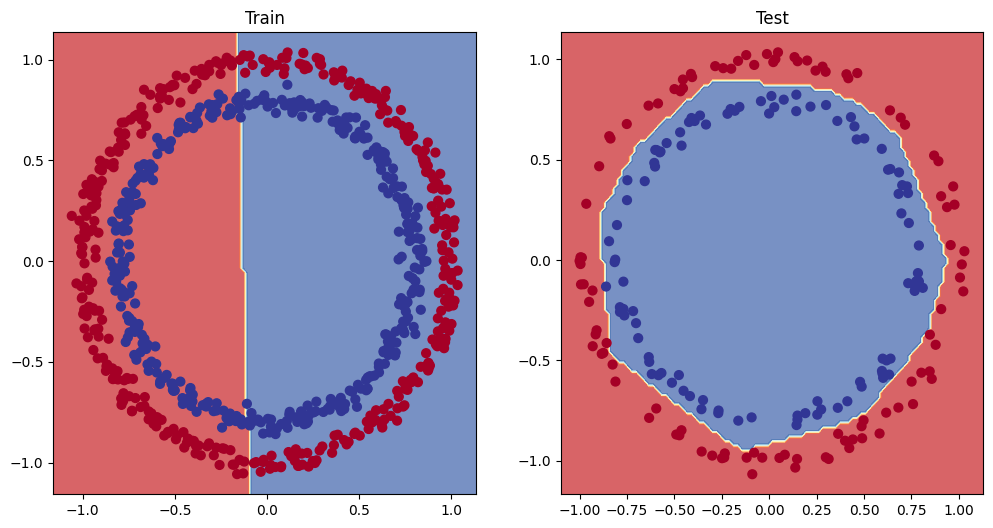

In [70]:
# plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)